- Does clustering work in high dimension?
    - apply DBSCAN or KMeans?
    - GridSearch
- Does reducing dimensionality help before clustering?
    - PCA or UMAP before with GridSearch
- Is DR going to make components reliably across different subsamples of data?
    - Reconstruction error or Procrustes distance of hold out sample
    

In [9]:
# basic data utils
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pal = sns.color_palette("hls", 10)

# Dimension reduction and clustering tools
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from umap import UMAP

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Data loading
from sklearn.datasets import fetch_openml

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Metrics for how good a clustering does
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, classification_report

In [18]:
df_cancer = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv').drop(columns=['Unnamed: 0'])
labels = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv').drop(columns=['Unnamed: 0'])

In [19]:
df_cancer.shape

(801, 20531)

In [20]:
# for the sake of visualization let's make a UMAP
vizdr = UMAP(n_neighbors=5, min_dist=0.25)
viz_coords = pd.DataFrame(vizdr.fit_transform(df_cancer), columns=['c1', 'c2'])
viz_coords['cancer_type'] = labels

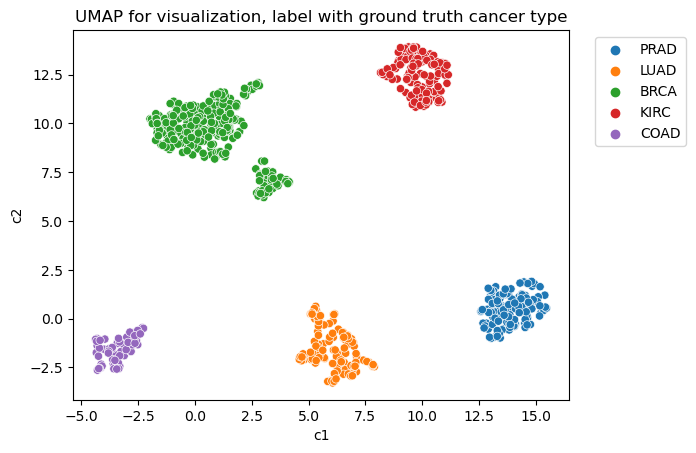

In [21]:
sns.scatterplot(data=viz_coords, x='c1', y='c2', hue='cancer_type')
plt.title('UMAP for visualization, label with ground truth cancer type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));

Eyeball meter suggests there may be something like 6 clusters and labels suggest 5 clusters. 

Let's try an elbow method and see what we see in high D

In [39]:
%pip install --user kneed

Note: you may need to restart the kernel to use updated packages.


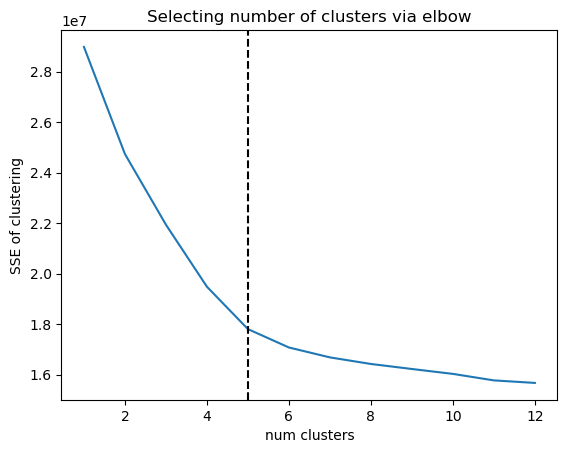

In [42]:
from kneed import KneeLocator

sse=[]
maxk = 13
for k in range(1,maxk):
    clust = cluster.KMeans(n_clusters=k)
    clust.fit(df_cancer)
    sse.append(clust.inertia_)

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="black", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

Now let's try the silhoutte method and see how the two methods agree or disagree

For n_clusters = 3 The average silhouette_score is : 0.16914531089163634
For n_clusters = 4 The average silhouette_score is : 0.20127932414890432
For n_clusters = 5 The average silhouette_score is : 0.22488527683456974
For n_clusters = 6 The average silhouette_score is : 0.22875604809637085
For n_clusters = 7 The average silhouette_score is : 0.18166959963720136


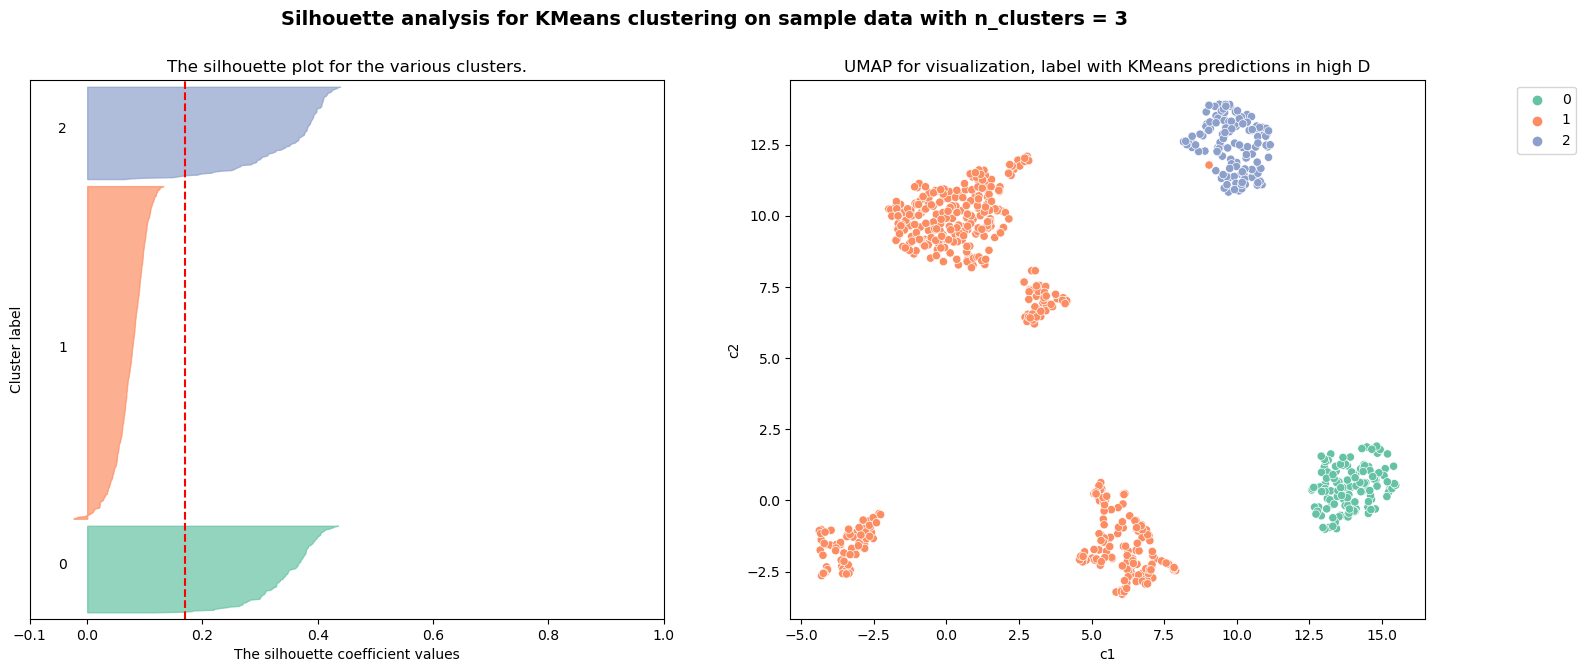

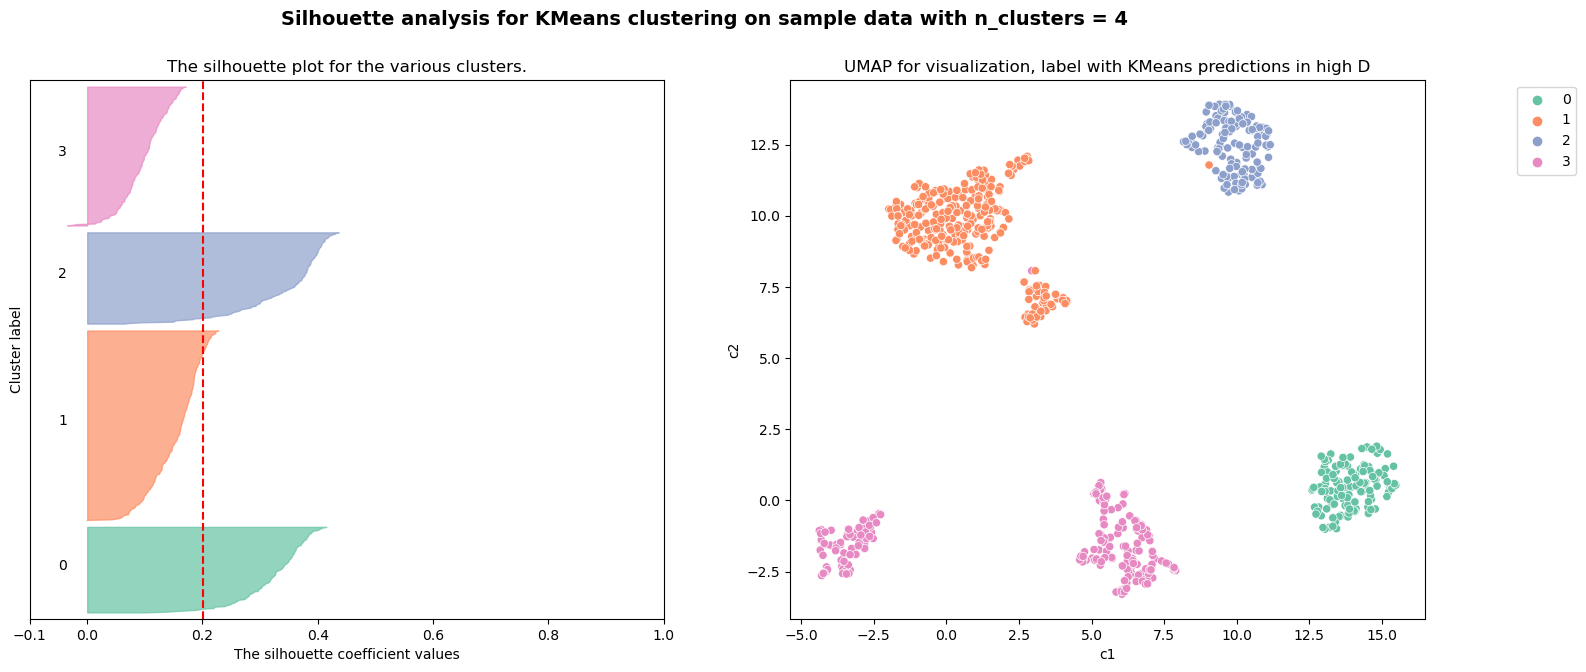

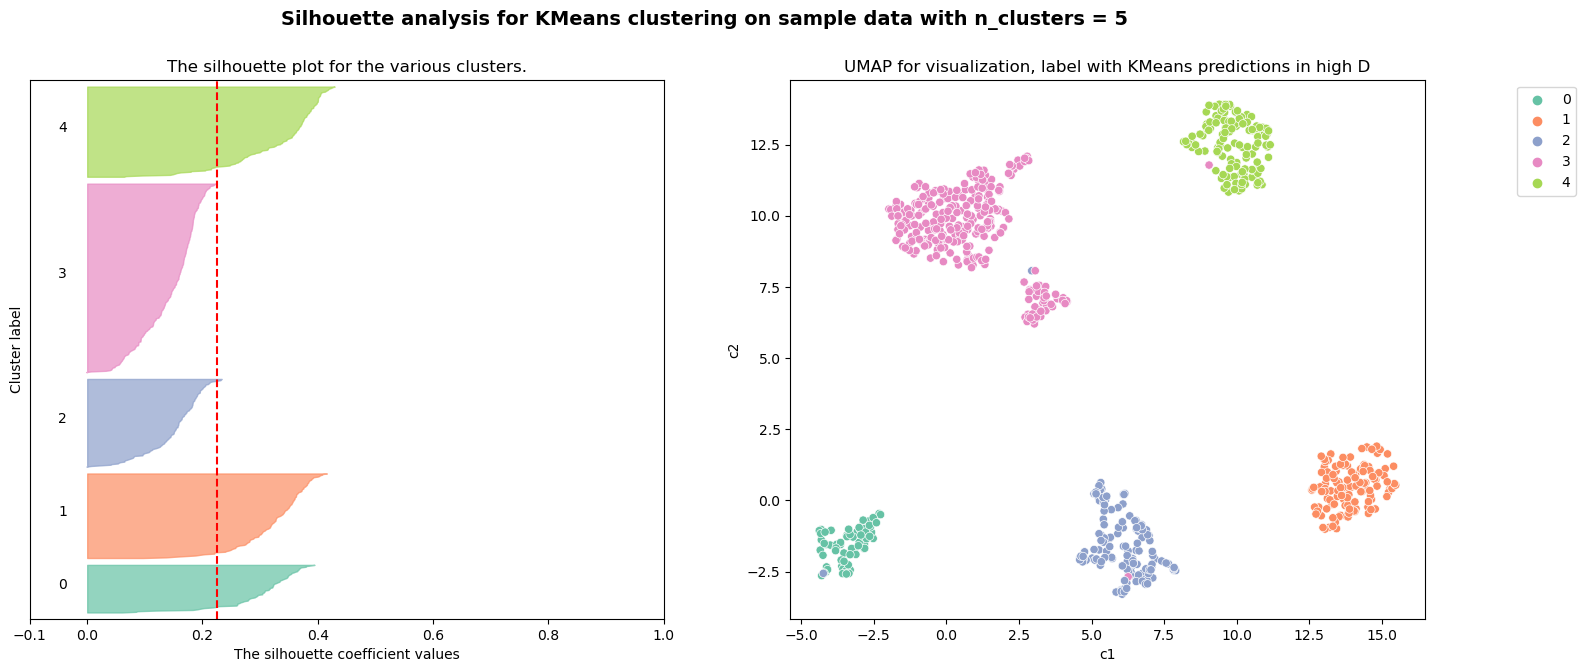

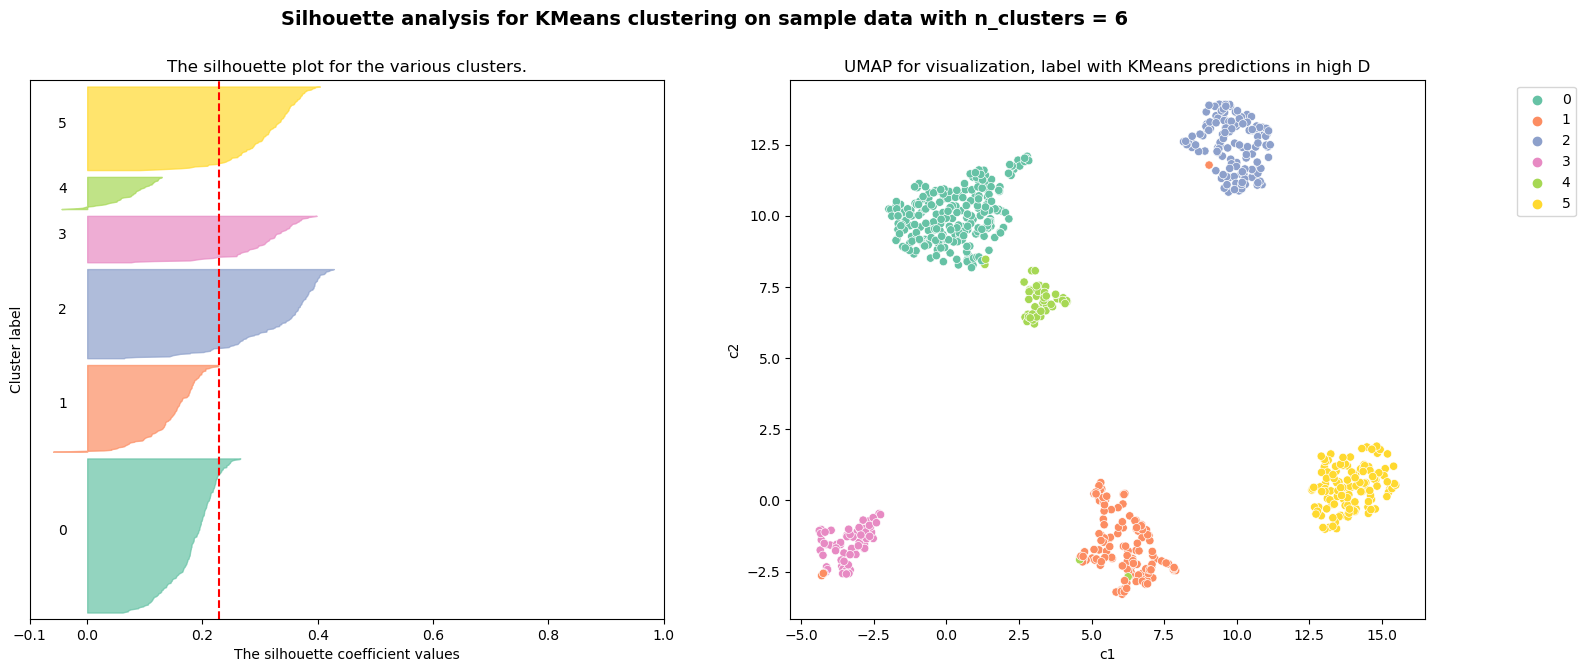

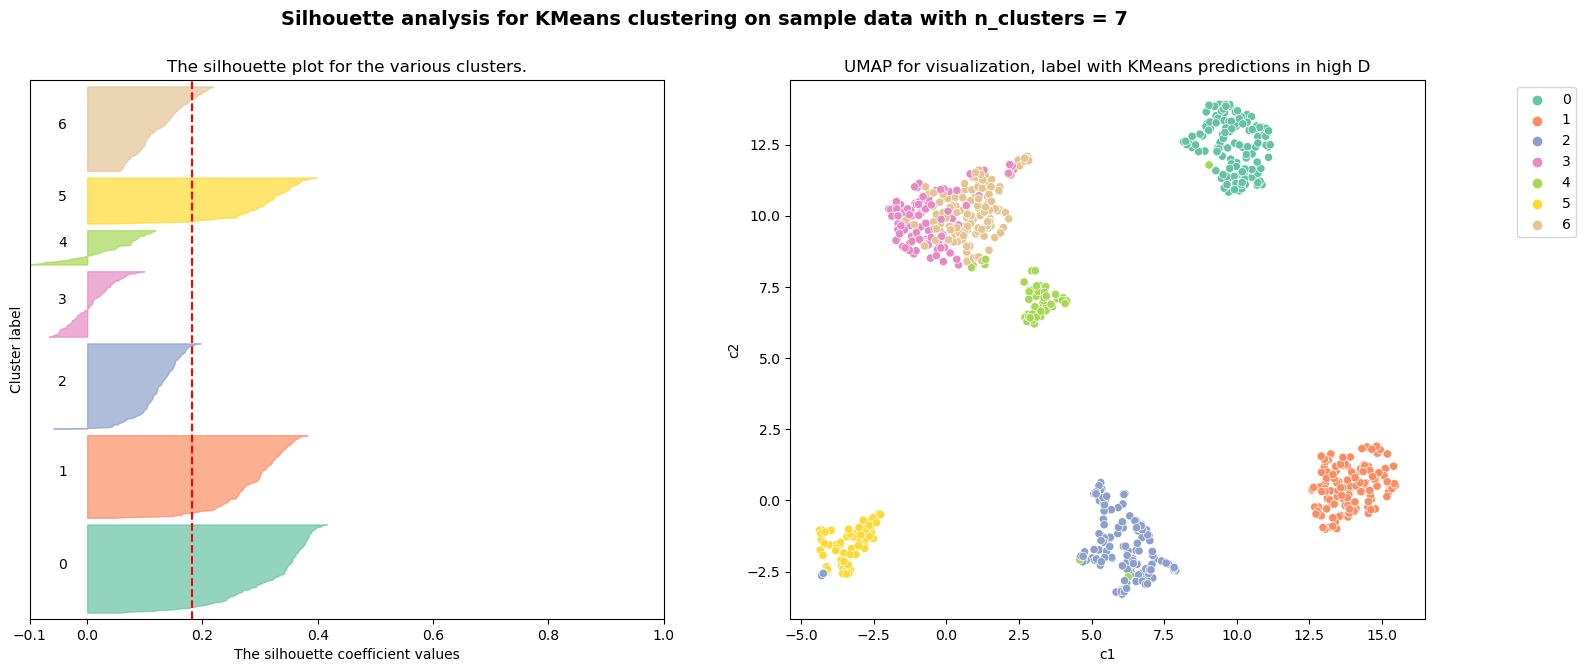

In [38]:
### copy/pasted with some mods from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X=df_cancer.values #turn into numpy

range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = sns.color_palette('Set2', n_clusters)[i]
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    predicted = clusterer.predict(X)
    viz_coords['prediction'] = predicted
    sns.scatterplot(data=viz_coords, x='c1', y='c2', hue='prediction', 
                    palette='Set2', ax=ax2)
    plt.title('UMAP for visualization, label with KMeans predictions in high D')
    ax2.legend(bbox_to_anchor=(1.25, 1));

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Ok, that's one vote for 5 and another vote for 6.  

It's worth thinking about that transition from 5 to 6 in the silhouette analysis.  Remember that this analysis is more than just "what score is best" (which says 6) but its also about the shapes of the plots.  

Recall that KMeans strongly prefers convex EVEN SIZED clusters. In 5 cluster the BRCA grouping (pink) is _much_ bigger than others. The splitting of it into 2 clusters evens things out for one of the clusters (good), but makes a very tiny cluster too (bad). On average this split leads to greater KMeans + Silhouette happiness. There are clearly SOME probelms here with KMeans... note a few negative scores from "far away" data points that are assigned to the wrong cluster... that's most likely driven by KMeans not dealing well with uneven size of clusters and maybe some non-convexity too.  So if we tried a GMM or DBSCAN or something else that can hang with those situations we _might_ get better clusters at 6 than with KMeans... leading to an even more clear silhouette preference for 6 clusters.



What might happen if we PCA the data first, then cluster?

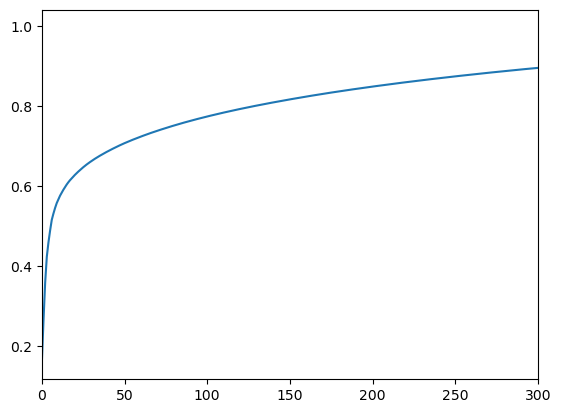

In [100]:
dimred = PCA()
dimred.fit(df_cancer)
sns.lineplot(np.cumsum(dimred.explained_variance_ratio_))
plt.xlim((0,300));

# looks like elbow is around 10 and 20 certainly captures beyond that
# and if we want to capture 80% of the variance than 200 does the trick

For n_clusters = 3 The average silhouette_score is : 0.3039898308239917
For n_clusters = 4 The average silhouette_score is : 0.35626743824681983
For n_clusters = 5 The average silhouette_score is : 0.3968302815792357
For n_clusters = 6 The average silhouette_score is : 0.40010553655286446
For n_clusters = 7 The average silhouette_score is : 0.34416708466459983


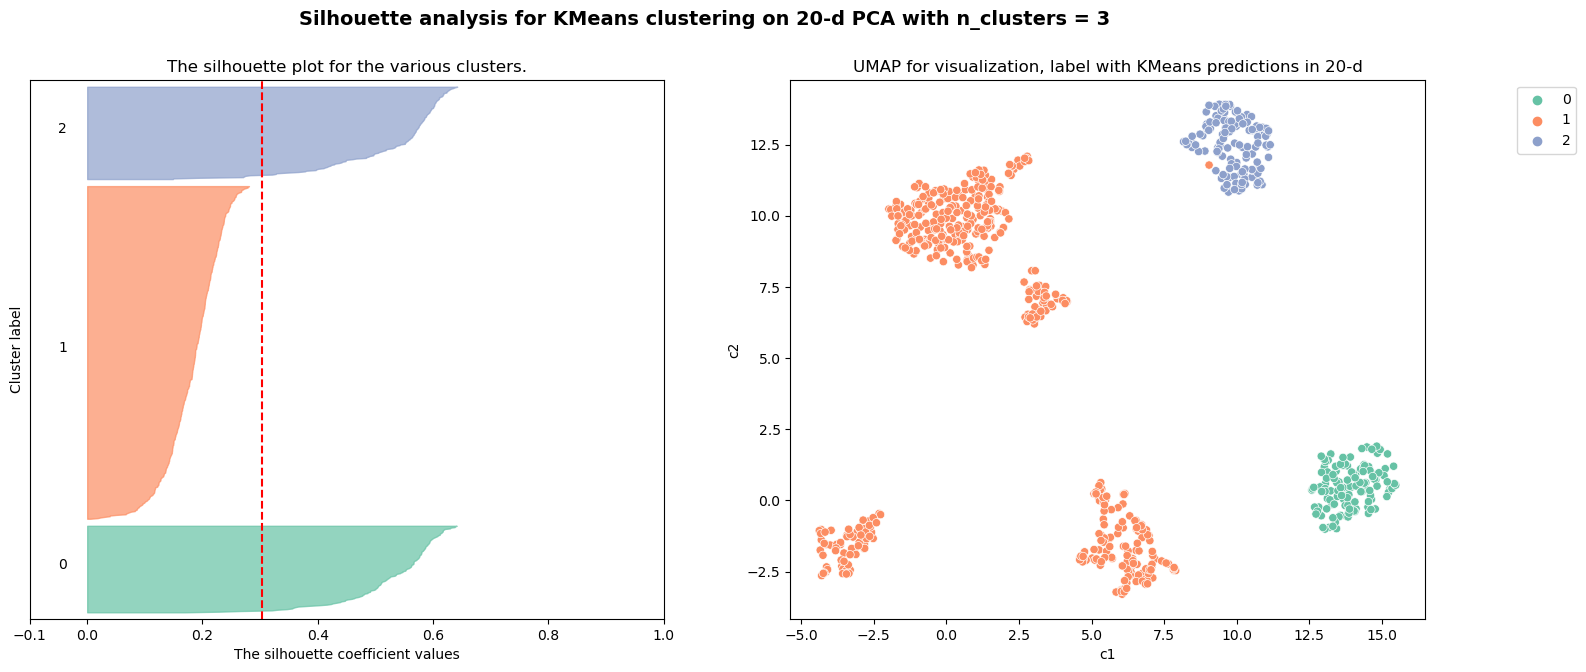

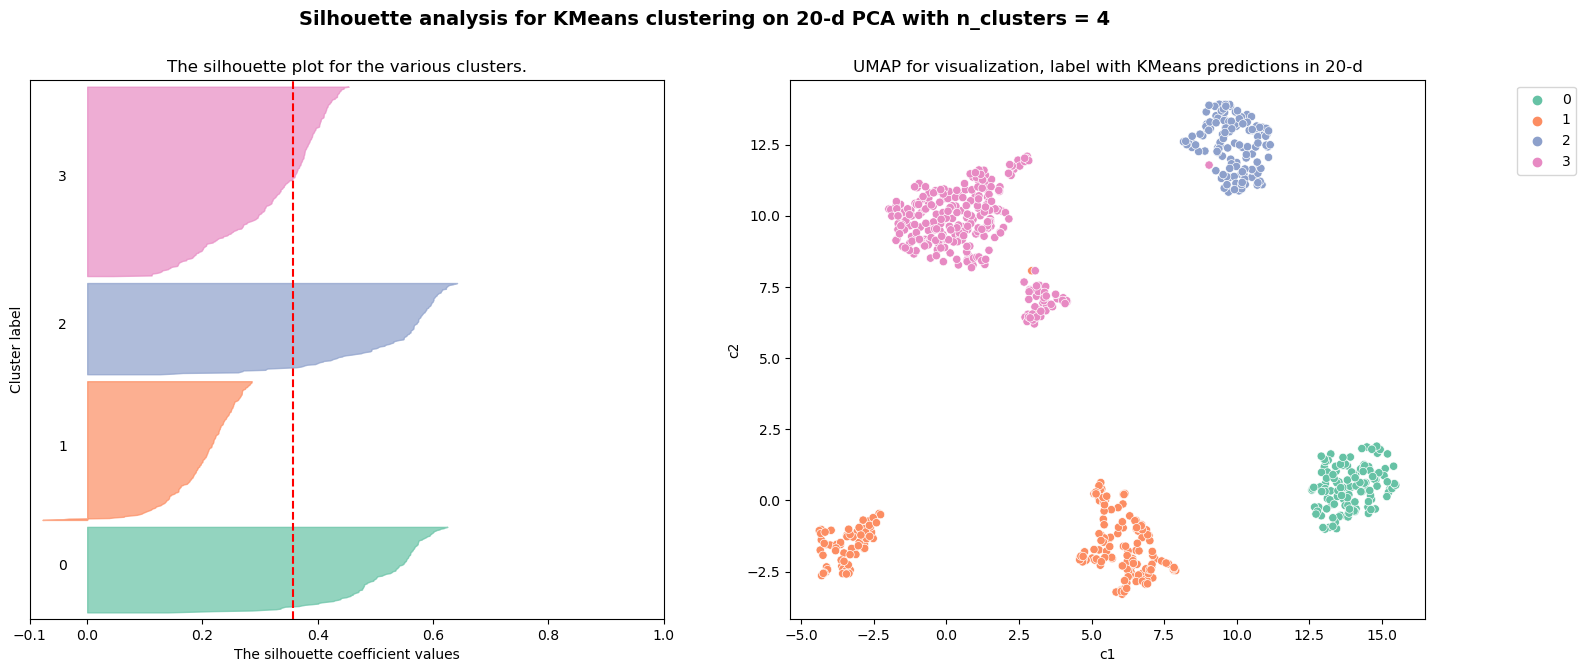

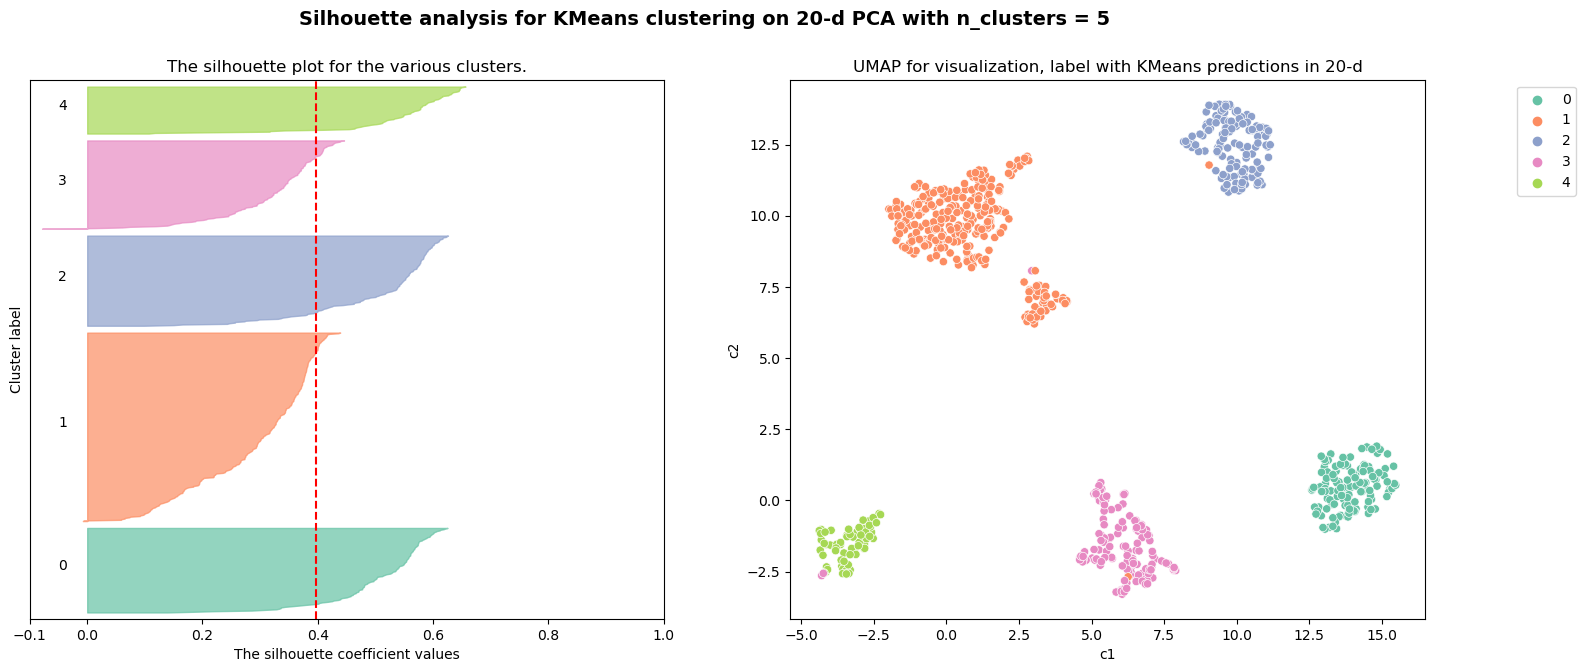

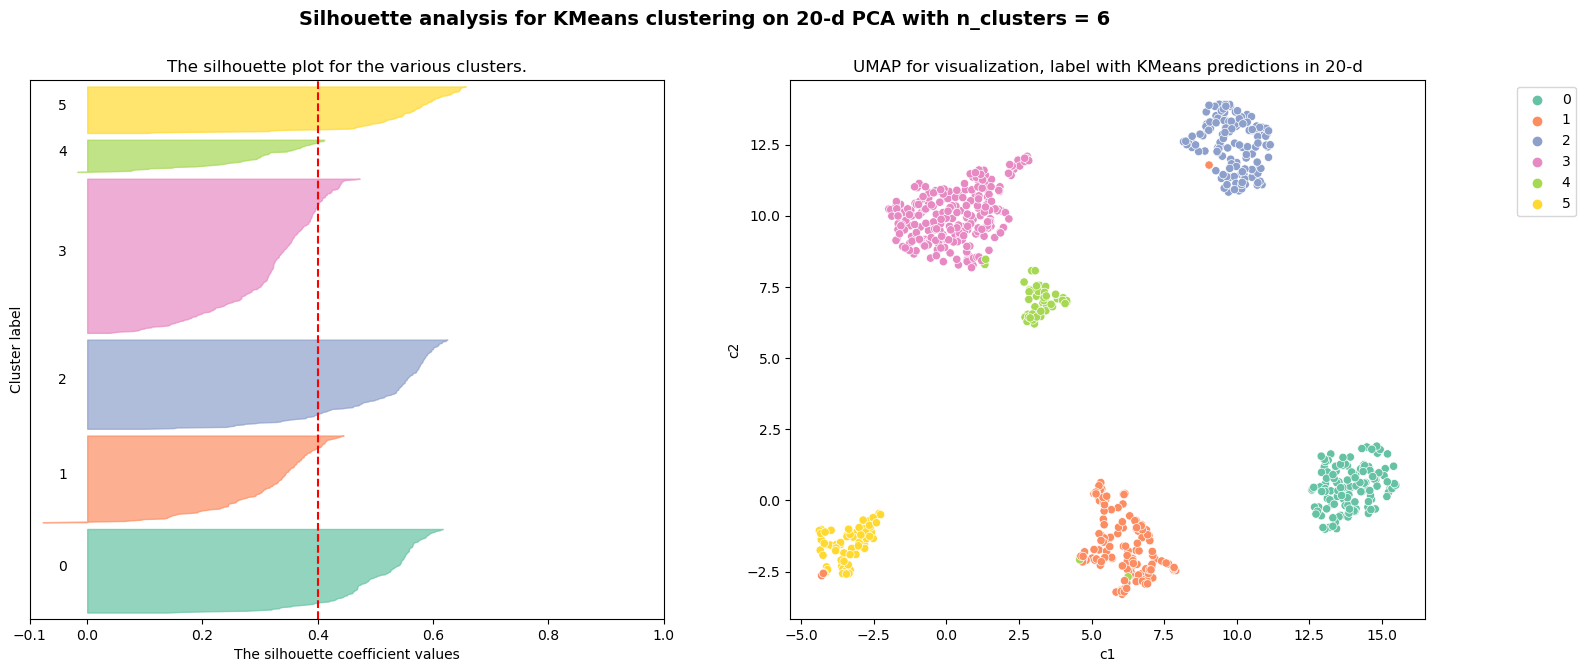

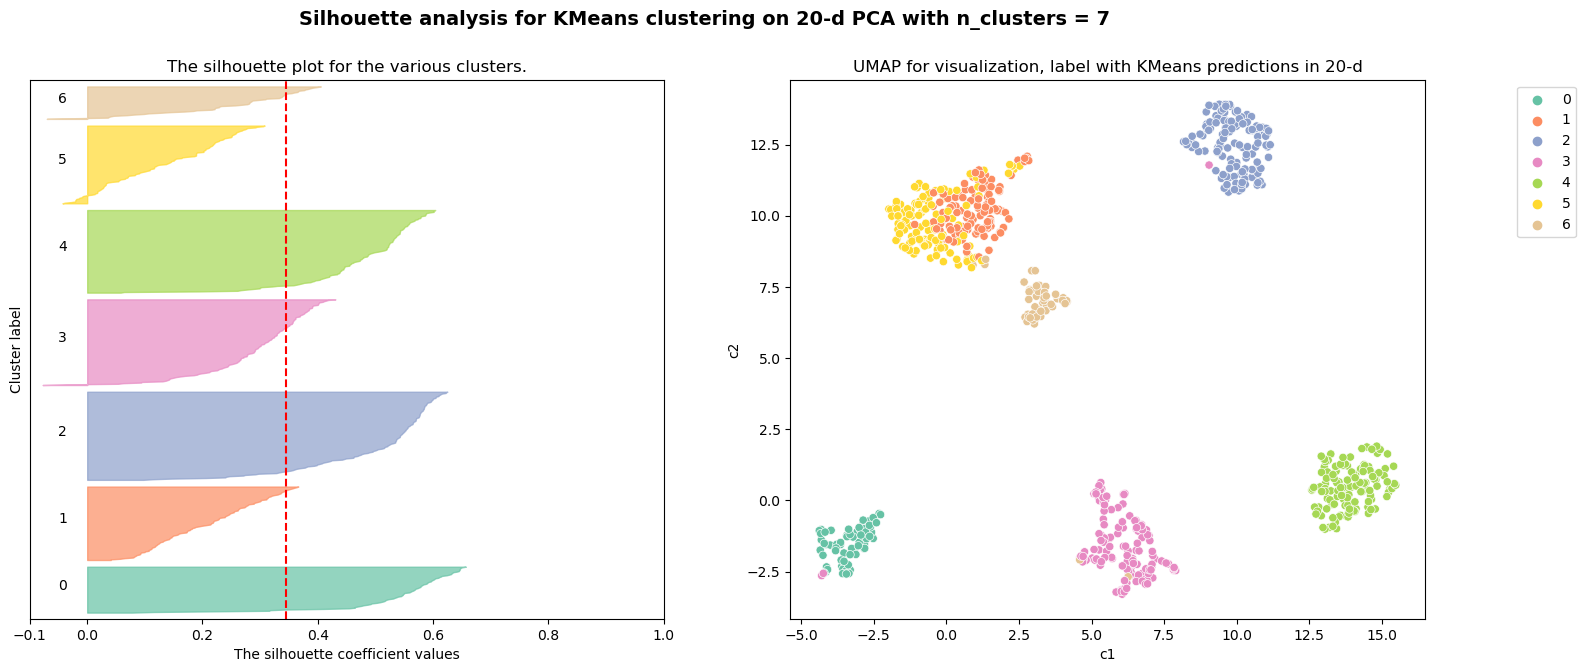

In [110]:
### copy/pasted with some mods from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline

dimred = PCA(n_components=20)
X= dimred.fit_transform(df_cancer.values)

range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = sns.color_palette('Set2', n_clusters)[i]
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    predicted = clusterer.predict(X)
    viz_coords['prediction'] = predicted
    sns.scatterplot(data=viz_coords, x='c1', y='c2', hue='prediction', 
                    palette='Set2', ax=ax2)
    plt.title(f'UMAP for visualization, label with KMeans predictions in {dimred.n_components_}-d')
    ax2.legend(bbox_to_anchor=(1.25, 1));

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on {dimred.n_components_}-d PCA with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Note that PCAing the situation doesn't really change our answers in nature, but it does improve 
- the number of dims, making GMM possible instead of KMeans should we wish to... it wasn't plausible before.. imagine estimating covariance in that number of dims!
- makes the silhouette score better by reducing the number of datapoints in far away clusters (possibly convexity improvement?)



OK lets do something different.  What if we do have (at least some) labels?  We can assume that the "right" number of clusters is related to ground truth. 

Below we have the standard cross-validation loop looking for the number of clusters that gives best adjusted rand index result.  I also show you a way to plot validation curves thats nice

But what if you don't have labels for every data point?  Well just do this for ONLY the datasamples you do have labels for :)



In [93]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

X, y = shuffle(df_cancer, labels.values.flatten(), random_state=0)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

cvscores = []
nclust = []
kfolds = 5

for n in range_n_clusters:
    clust = cluster.KMeans(n_clusters=n)
    cvscores.append( 
        cross_val_score(clust, X, y, cv=kfolds, 
                        scoring='adjusted_rand_score') )
    nclust.append( kfolds * [n] )

cvscores = np.array(cvscores).flatten()
nclust = np.array(nclust).flatten()

validation_curve = pd.DataFrame({'n_clusters':nclust, 'ARI':cvscores})

CPU times: user 14min 57s, sys: 26.7 s, total: 15min 24s
Wall time: 1min 5s


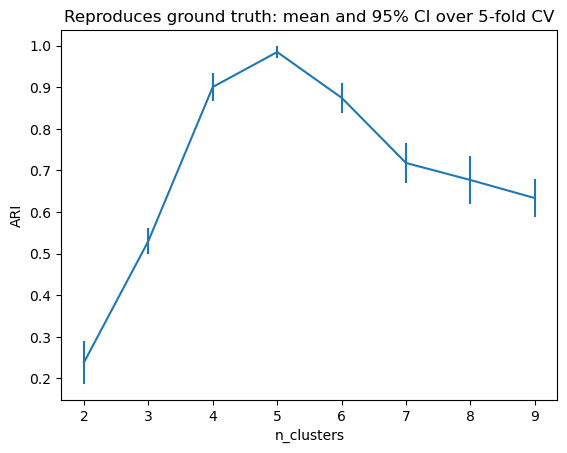

In [94]:
from matplotlib.ticker import MaxNLocator

sns.lineplot(validation_curve, x='n_clusters', y='ARI',
             err_style="bars", errorbar=("se", 1.96));

# prevent auto ticks from generating non-integer ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(f'Reproduces ground truth: mean and 95% CI over {kfolds}-fold CV');

Great another vote for 5 clusters... but recall that this is already taking ground truth as the default by the way this metric is constructed.  So we (a) very much expected this result and (b) still ahve to worry about the situation where our ground truth is not accurately capturing the true nature of variability in our population

Lets examine how REPEATABLE our clusterings are.  After all some approaches/models/algos may give us better answers on average but have huge variability, while others are nearly as good on average but much more reliable.  We would tend to prefer the latter :)

Recall that there are two sources of randomness in clustering.
- Sample randomness (different sample from same population yields different results)
- Algorithm randomness (random seeds give different results in optimization)

We can take several approaches to this... we can reuse ARI/CV approach above

In [90]:
%%time
# this version makes a default clustering with ALL data
# and we ask how similar clustering is with subsamples of the data!

#from sklearn.model_selection import cross_val_score
#from sklearn.utils import shuffle

X, _ = shuffle(df_cancer, labels.values.flatten(), random_state=0)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

cvscores = []
nclust = []
kfolds = 5 

for n in range_n_clusters:
    clust = cluster.KMeans(n_clusters=n)
    
    ### HERES THE DIFFERENCE FROM BEFORE!!!!
    y = clust.fit_predict(X) # default clustering with all data
    
    cvscores.append( 
        cross_val_score(clust, X, y, cv=kfolds, 
                        scoring='adjusted_rand_score') )
    nclust.append( kfolds * [n] )

cvscores = np.array(cvscores).flatten()
nclust = np.array(nclust).flatten()

validation_curve = pd.DataFrame({'n_clusters':nclust, 'ARI':cvscores})

CPU times: user 17min 14s, sys: 1min 1s, total: 18min 15s
Wall time: 1min 20s


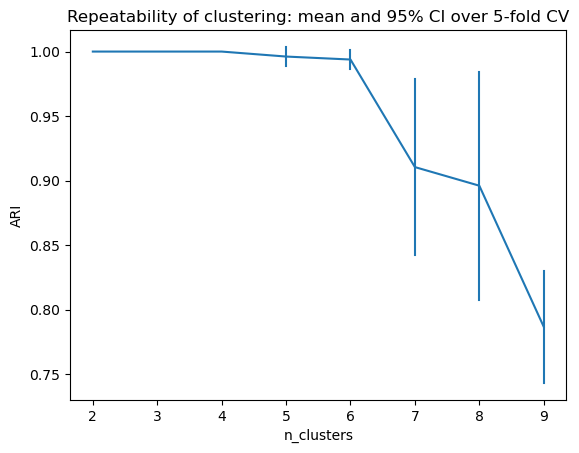

In [91]:
from matplotlib.ticker import MaxNLocator

sns.lineplot(validation_curve, x='n_clusters', y='ARI',
             err_style="bars", errorbar=("se", 1.96));

# prevent auto ticks from generating non-integer ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(f'Repeatability of clustering: mean and 95% CI over {kfolds}-fold CV');

If we are testing repeatability on a dimension reduction instead of a clustering we can do a Procrustes distance


NOTE I am not advocating for doing this particularly to choose dimensionality... but it may be useful to check other hyperparameters on UMAP or to compare UMAP vs tSNE vs something else

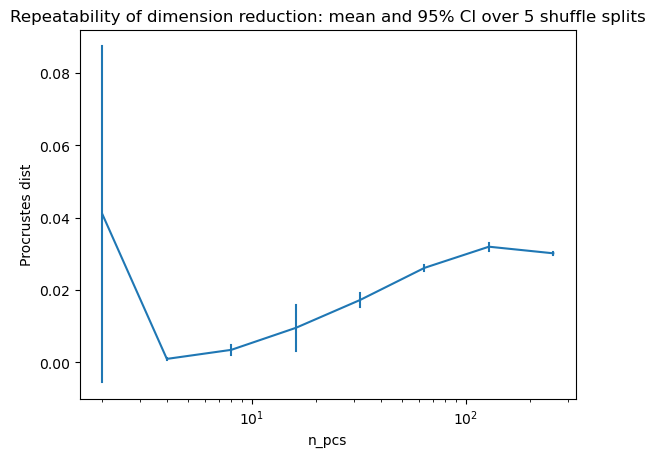

In [123]:
from scipy.spatial import procrustes
from numpy.random import permutation

X = df_cancer.values
samp_size = int(0.5*len(X))

range_pcs = [2,4,8,16,32,64,128,256]

shufscores = []
npcs = []
repeats = 5 


for n in range_pcs:

    dimred = PCA(n_components=n)
    
    for _ in range(repeats):
        sample = permutation(len(X))[:samp_size]
        trans1 = dimred.fit_transform(X[sample])
        trans2 = dimred.fit(X).transform(X[sample])
        _, _, disparity = procrustes(trans1, trans2)
        shufscores.append( disparity ) 
        npcs.append(n)
    
shufscores = np.array(shufscores).flatten()
npcs = np.array(npcs).flatten()

validation_curve = pd.DataFrame({'n_pcs':npcs, 'Procrustes dist':shufscores})

sns.lineplot(validation_curve, x='n_pcs', y='Procrustes dist',
             err_style="bars", errorbar=("se", 1.96));
ax = plt.gca()
ax.set_xscale('log')
plt.title(f'Repeatability of dimension reduction: mean and 95% CI over {repeats} shuffle splits');

OK lets do something on a different dataset, one that is less neat than we've been working with up til now



In [95]:
# warning this can take 30s to 1min

# Load count matrix 
df_GSE146773 = pd.read_csv('GSE146773/RawCounts.csv')

# Rename first column to 'Well_Plate', make it the index
df_GSE146773.columns = ['Well_Plate'] +  list(df_GSE146773.columns[1:])
df_GSE146773.set_index('Well_Plate',inplace=True)
df_GSE146773

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000286234,ENSG00000286235,ENSG00000286237,ENSG00000286239,ENSG00000286243,ENSG00000286255,ENSG00000286261,ENSG00000286264,ENSG00000286265,ENSG00000286268
Well_Plate,,,,,,,,,,,,,,,,,,,,,
A10_355,20.0,0.0,29.0,4.00,9.00,0.0,0.0,17.0,5.0,18.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,2.46
A10_356,42.0,0.0,15.0,0.00,14.00,0.0,0.0,11.0,19.0,7.0,...,0.0,2.54,0.0,15.04,0.0,0.0,1.36,0.0,0.0,0.00
A10_357,8.0,0.0,37.0,0.00,22.00,0.0,0.0,56.0,29.0,33.0,...,0.0,1.33,0.0,0.00,0.0,0.0,1.09,0.0,0.0,0.00
A11_355,22.0,0.0,27.0,1.14,13.86,0.0,0.0,8.0,8.0,26.0,...,0.0,0.00,0.0,8.00,0.0,0.0,0.00,0.0,0.0,0.00
A11_356,133.0,0.0,17.0,10.00,7.00,0.0,0.0,45.0,27.0,27.0,...,0.0,0.00,0.0,20.88,0.0,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_356,19.0,0.0,29.0,6.00,14.00,0.0,0.0,41.0,9.0,34.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
P8_357,38.0,0.0,20.0,1.21,31.79,0.0,0.0,22.0,12.0,27.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
P9_355,59.0,0.0,19.0,6.00,17.00,0.0,6.0,60.0,0.0,11.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00


In [15]:
# for the sake of visualization let's make a UMAP
vizdr_sc = UMAP(n_neighbors=150, min_dist=0.25)
vizsc_coords = pd.DataFrame(vizdr_sc.fit_transform(df_GSE146773), columns=['c1', 'c2'])

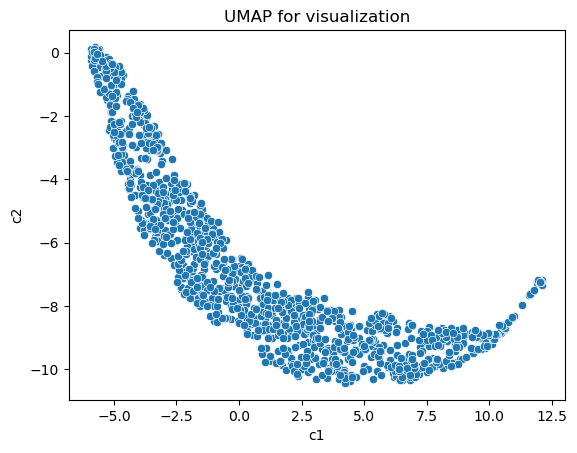

In [16]:
sns.scatterplot(data=vizsc_coords, x='c1', y='c2')
plt.title('UMAP for visualization');

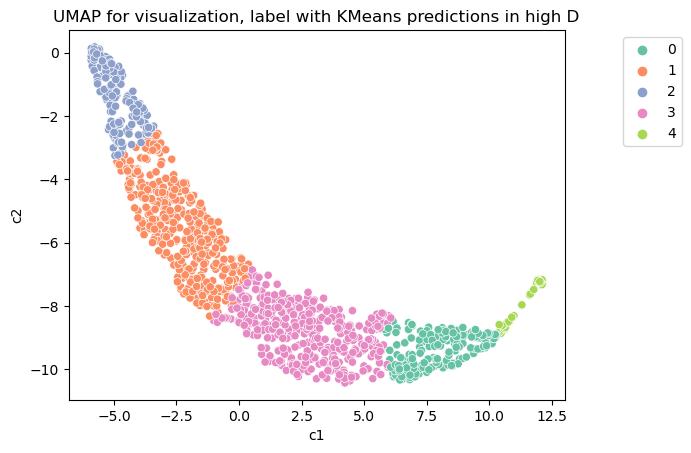

In [17]:
clustsc = cluster.KMeans(n_clusters=5)
clustsc.fit(df_GSE146773)
predicted = clustsc.predict(df_GSE146773)
vizsc_coords['prediction'] = predicted
sns.scatterplot(data=vizsc_coords, x='c1', y='c2', hue='prediction', palette='Set2')
plt.title('UMAP for visualization, label with KMeans predictions in high D')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));